# This notebook demonstrates using auto tune to find the best hyperparameters for a pytorch regressor
# This example is small on purpose for demonstration, if you make a larger problem it may not work in a jupyter notebook.

Import standard libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from gumps.apps.parametric_sweep import ParametricSweepApp
from gumps.solvers.sampler import SamplerSolverParameters
from gumps.solvers.regressors.pytorch_regressor import TorchMultiLayerPerceptronRegressor, TorchMultiLayerPerceptronRegressionParameters, OptunaParameters
from gumps.graph.regressor import RegressorPlotParameters, RegressorPlot

from gumps.studies.batch_study import AbstractBatchStudy
from typing import Callable

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create a trivial problem

In [2]:
x = np.linspace(0, 5, 1000)
y = np.linspace(0, 5, 1000)

X, Y = np.meshgrid(x, y)


Z = X+Y

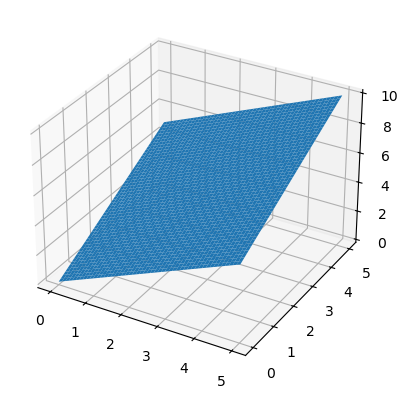

In [3]:
# Create a figure
fig = plt.figure()

# Create a 3D axis
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, Z)

# Create a Batch interface for the problem

In [4]:
class BatchFunction(AbstractBatchStudy):
    "batch version of sphere study (designed to approximate surrogate model)"

    def __init__(self):
        ...

    def start(self):
        "initialize this study"

    def stop(self):
        "handle shutdown tasks"

    def run(self, input_data:pd.DataFrame, processing_function:Callable) -> pd.DataFrame:
        "run the batch simulation"
        z = input_data['x'] + input_data['y']

        output_data = pd.DataFrame({'z':z})

        self.save_results(input_data, output_data)

        return processing_function(output_data)

# Sample the function

In [5]:
parameters_plot = SamplerSolverParameters(
		number_of_samples = 100,
		lower_bound = pd.Series({'x':0, 'y':0}),
		upper_bound = pd.Series({'x':5, 'y':5}),
		sampler = "sobol"
		)

def processing_function(df:pd.DataFrame) -> pd.DataFrame:
    return df

batch = BatchFunction()

app_sample = ParametricSweepApp(parameters=parameters_plot,
			processing_function=processing_function,
			directory=None,
			batch=batch)

app_sample.run()

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


# Train a regressor

In [6]:
reg_data = TorchMultiLayerPerceptronRegressionParameters(input_data=app_sample.factors,
                                    output_data=app_sample.responses,
                                    learning_rate="adaptive",
                                    hidden_layer_sizes=(2,),
                                    learning_rate_patience=100,
                                    learning_rate_factor=0.5,
                                    learning_rate_init=1e-3,
                                    early_stopping_patience=200,
                                    validation_fraction=0.33,
                                    max_iter=1000,
                                    batch_size=4,
                                    train_test_split="sequential",
                                    enable_progress_bar=True)

regressor = TorchMultiLayerPerceptronRegressor(reg_data)
regressor.fit()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 9     
---------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 17.09it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 420: 100%|██████████| 17/17 [00:00<00:00, 140.94it/s, val_loss=8.77e-5, train_loss=3.32e-5] 


# Check the regressor

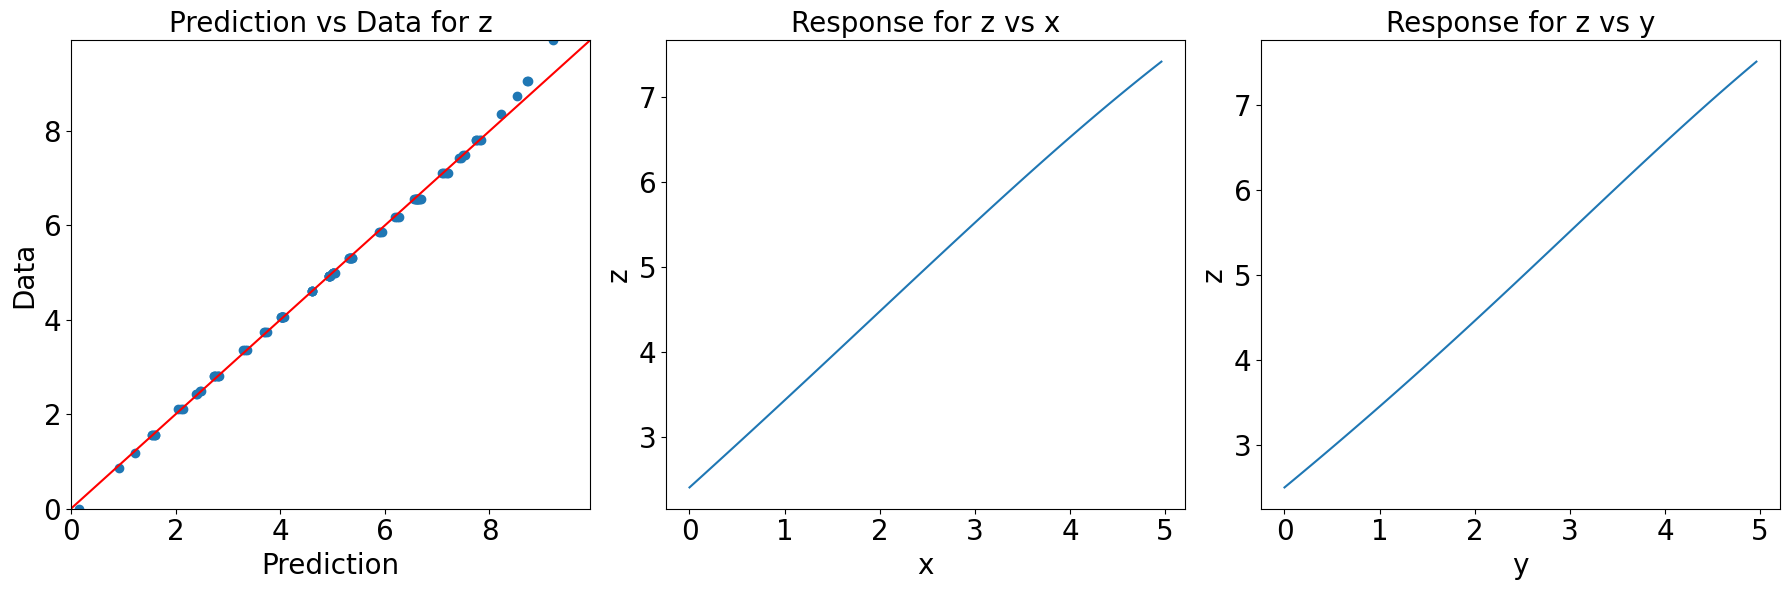

nrmse 0.010062753909249161


In [7]:
params = RegressorPlotParameters(regressor,
                                 regressor.parameters.input_data.mean(),
                                 regressor.parameters.input_data.min(),
                                 regressor.parameters.input_data.max())

reg_plot = RegressorPlot(params)

reg_plot.plot()

print("nrmse", regressor.error_metrics()['nrmse'])


before = pd.Series({'batch_size':regressor.parameters.batch_size,
                    'learning_rate_init':regressor.parameters.learning_rate_init,
                    'learning_rate_factor':regressor.parameters.learning_rate_factor,
                    'hidden_layer_sizes':regressor.parameters.hidden_layer_sizes,
                    'nrmse':regressor.error_metrics()['nrmse']})

# Setup and run auto tune

In [8]:
parameters = OptunaParameters(
    number_of_trials=100,
    min_epochs=50)

In [9]:
regressor.auto_tune(parameters)

[I 2024-01-24 09:41:58,593] A new study created in memory with name: no-name-7126f14c-f78e-4e22-b8b8-c6770cad1869
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 65    
---------------------------------------
65        Trainable params
0         Non-trainable params
65        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 42.75it/s, val_loss=2.27e-6, train_loss=1.74e-6]  

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 33.55it/s, val_loss=2.27e-6, train_loss=1.74e-6]


[I 2024-01-24 09:42:27,809] Trial 0 finished with value: 0.001383080052812754 and parameters: {'batch_size': 9, 'learning_rate_init': 0.006748505181016175, 'layers': 1, 'learning_rate_factor': 0.1785171179588473, 'layer_size_0': 4}. Best is trial 0 with value: 0.001383080052812754.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 2.1 K 
---------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 151.79it/s, val_loss=0.00216, train_loss=0.00229]

[I 2024-01-24 09:42:31,191] Trial 1 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 18.2 K
---------------------------------------
18.2 K    Trainable params
0         Non-trainable params
18.2 K    Total params
0.073     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 148.87it/s, val_loss=0.00199, train_loss=0.00103]

[I 2024-01-24 09:42:34,759] Trial 2 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 33    
---------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 2/2 [00:00<00:00, 189.63it/s, val_loss=0.392, train_loss=0.381]

[I 2024-01-24 09:42:48,523] Trial 3 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 71.0 K
---------------------------------------
71.0 K    Trainable params
0         Non-trainable params
71.0 K    Total params
0.284     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 167.08it/s, val_loss=0.000201, train_loss=0.000154]

[I 2024-01-24 09:42:51,931] Trial 4 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 255   
---------------------------------------
255       Trainable params
0         Non-trainable params
255       Total params
0.001     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 164.57it/s, val_loss=0.00477, train_loss=0.00391]

[I 2024-01-24 09:42:55,450] Trial 5 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 33.7 K
---------------------------------------
33.7 K    Trainable params
0         Non-trainable params
33.7 K    Total params
0.135     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 143.60it/s, val_loss=0.00147, train_loss=0.00151]

[I 2024-01-24 09:42:59,138] Trial 6 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 513   
---------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 152.90it/s, val_loss=0.000565, train_loss=0.00048] 

[I 2024-01-24 09:43:17,667] Trial 7 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 5.7 K 
---------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 150.92it/s, val_loss=0.0316, train_loss=0.0327]

[I 2024-01-24 09:43:21,115] Trial 8 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 271 K 
---------------------------------------
271 K     Trainable params
0         Non-trainable params
271 K     Total params
1.086     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 127.48it/s, val_loss=0.0136, train_loss=0.0118]

[I 2024-01-24 09:43:24,920] Trial 9 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 137 K 
---------------------------------------
137 K     Trainable params
0         Non-trainable params
137 K     Total params
0.552     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 178.44it/s, val_loss=0.00251, train_loss=0.00336]

[I 2024-01-24 09:43:38,544] Trial 10 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 136 K 
---------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.547     Total estimated model params size (MB)


Epoch 426: 100%|██████████| 2/2 [00:00<00:00, 62.08it/s, val_loss=5.2e-5, train_loss=3.66e-5]    


[I 2024-01-24 09:43:54,422] Trial 11 finished with value: 0.0022275932084863384 and parameters: {'batch_size': 6, 'learning_rate_init': 0.0030883542740160635, 'layers': 4, 'learning_rate_factor': 0.8851010462265582, 'layer_size_0': 4, 'layer_size_1': 4, 'layer_size_2': 8, 'layer_size_3': 9}. Best is trial 0 with value: 0.001383080052812754.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 8.9 K 
---------------------------------------
8.9 K     Trainable params
0         Non-trainable params
8.9 K     Total params
0.035     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 50: 100%|██████████| 2/2 [00:00<00:00, 195.95it/s, val_loss=0.254, train_loss=0.247]

[I 2024-01-24 09:43:58,248] Trial 12 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 4.8 K 
---------------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 2/2 [00:00<00:00, 125.50it/s, val_loss=0.000645, train_loss=0.000731]

[I 2024-01-24 09:44:01,917] Trial 13 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 40.5 K
---------------------------------------
40.5 K    Trainable params
0         Non-trainable params
40.5 K    Total params
0.162     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 154.75it/s, val_loss=0.00156, train_loss=0.00262]

[I 2024-01-24 09:44:15,473] Trial 14 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 5.3 K 
---------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 170.42it/s, val_loss=1.75e-5, train_loss=2.25e-5] 

[I 2024-01-24 09:44:23,040] Trial 15 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 17.8 K
---------------------------------------
17.8 K    Trainable params
0         Non-trainable params
17.8 K    Total params
0.071     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 147.31it/s, val_loss=0.00244, train_loss=0.00304]

[I 2024-01-24 09:44:26,652] Trial 16 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 457   
---------------------------------------
457       Trainable params
0         Non-trainable params
457       Total params
0.002     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 2/2 [00:00<00:00, 187.50it/s, val_loss=0.00248, train_loss=0.00238]

[I 2024-01-24 09:44:40,653] Trial 17 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 33    
---------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 160.11it/s, val_loss=0.00943, train_loss=0.00907]

[I 2024-01-24 09:44:44,341] Trial 18 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 18.8 K
---------------------------------------
18.8 K    Trainable params
0         Non-trainable params
18.8 K    Total params
0.075     Total estimated model params size (MB)


Epoch 383: 100%|██████████| 1/1 [00:00<00:00, 31.88it/s, val_loss=4.81e-6, train_loss=1.64e-6] 


[I 2024-01-24 09:44:57,385] Trial 19 finished with value: 0.002969614035783587 and parameters: {'batch_size': 7, 'learning_rate_init': 0.004913116854376748, 'layers': 6, 'learning_rate_factor': 0.8261791103920937, 'layer_size_0': 9, 'layer_size_1': 5, 'layer_size_2': 4, 'layer_size_3': 4, 'layer_size_4': 1, 'layer_size_5': 1}. Best is trial 0 with value: 0.001383080052812754.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 46.6 K
---------------------------------------
46.6 K    Trainable params
0         Non-trainable params
46.6 K    Total params
0.186     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 200: 100%|██████████| 2/2 [00:00<00:00, 169.52it/s, val_loss=1.96e-5, train_loss=3.42e-6] 

[I 2024-01-24 09:45:11,298] Trial 20 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 18.3 K
---------------------------------------
18.3 K    Trainable params
0         Non-trainable params
18.3 K    Total params
0.073     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 162.51it/s, val_loss=0.00323, train_loss=0.00231]

[I 2024-01-24 09:45:14,871] Trial 21 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 10.8 K
---------------------------------------
10.8 K    Trainable params
0         Non-trainable params
10.8 K    Total params
0.043     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 165.90it/s, val_loss=0.000352, train_loss=0.00015] 

[I 2024-01-24 09:45:18,601] Trial 22 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 10.1 K
---------------------------------------
10.1 K    Trainable params
0         Non-trainable params
10.1 K    Total params
0.040     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 2/2 [00:00<00:00, 188.81it/s, val_loss=0.0853, train_loss=0.081] 

[I 2024-01-24 09:45:32,559] Trial 23 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 6.0 K 
---------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 128.07it/s, val_loss=0.00484, train_loss=0.00609]

[I 2024-01-24 09:45:36,082] Trial 24 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 4.9 K 
---------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.020     Total estimated model params size (MB)


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 42.16it/s, val_loss=3.7e-8, train_loss=4.75e-8]  

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 31.01it/s, val_loss=3.7e-8, train_loss=4.75e-8]


[I 2024-01-24 09:46:15,354] Trial 25 finished with value: 0.00020964965450383303 and parameters: {'batch_size': 8, 'learning_rate_init': 0.0046986330111479695, 'layers': 4, 'learning_rate_factor': 0.6808957272824357, 'layer_size_0': 5, 'layer_size_1': 4, 'layer_size_2': 7, 'layer_size_3': 4}. Best is trial 25 with value: 0.00020964965450383303.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 38.0 K
---------------------------------------
38.0 K    Trainable params
0         Non-trainable params
38.0 K    Total params
0.152     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 151.71it/s, val_loss=0.000322, train_loss=0.000287]

[I 2024-01-24 09:46:18,983] Trial 26 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 1.6 K 
---------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 179.20it/s, val_loss=0.000637, train_loss=0.000535]

[I 2024-01-24 09:46:22,437] Trial 27 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 121   
---------------------------------------
121       Trainable params
0         Non-trainable params
121       Total params
0.000     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 167.24it/s, val_loss=0.135, train_loss=0.127]

[I 2024-01-24 09:46:26,010] Trial 28 pruned. Trial was pruned at epoch 50.


Epoch 50: 100%|██████████| 1/1 [00:15<00:00,  0.07it/s, val_loss=0.135, train_loss=0.127] 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 10.7 K
---------------------------------------
10.7 K    Trainable params
0         Non-trainable params
10.7 K    Total params
0.043     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 135.68it/s, val_loss=0.0069, train_loss=0.00567] 

[I 2024-01-24 09:46:44,897] Trial 29 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 10.4 K
---------------------------------------
10.4 K    Trainable params
0         Non-trainable params
10.4 K    Total params
0.042     Total estimated model params size (MB)


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 165.84it/s, val_loss=2.11e-6, train_loss=2.57e-6] 

[I 2024-01-24 09:46:53,051] Trial 30 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 8.8 K 
---------------------------------------
8.8 K     Trainable params
0         Non-trainable params
8.8 K     Total params
0.035     Total estimated model params size (MB)


Epoch 800: 100%|██████████| 1/1 [00:00<00:00, 181.58it/s, val_loss=3.95e-7, train_loss=3.42e-8]

[I 2024-01-24 09:47:28,184] Trial 31 pruned. Trial was pruned at epoch 800.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 1.4 K 
---------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 166.29it/s, val_loss=0.000392, train_loss=0.00036] 

[I 2024-01-24 09:47:32,201] Trial 32 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 22.3 K
---------------------------------------
22.3 K    Trainable params
0         Non-trainable params
22.3 K    Total params
0.089     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 2/2 [00:00<00:00, 183.09it/s, val_loss=0.00286, train_loss=0.00208]

[I 2024-01-24 09:47:41,343] Trial 33 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 7.6 K 
---------------------------------------
7.6 K     Trainable params
0         Non-trainable params
7.6 K     Total params
0.030     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 160.75it/s, val_loss=0.00012, train_loss=0.00013]  

[I 2024-01-24 09:47:44,674] Trial 34 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 3.6 K 
---------------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.014     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 164.70it/s, val_loss=0.00138, train_loss=0.0015]   

[I 2024-01-24 09:47:48,136] Trial 35 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 1.2 K 
---------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 154.00it/s, val_loss=0.00049, train_loss=0.00034]  

[I 2024-01-24 09:47:51,519] Trial 36 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 65    
---------------------------------------
65        Trainable params
0         Non-trainable params
65        Total params
0.000     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 2/2 [00:00<00:00, 194.53it/s, val_loss=0.000869, train_loss=0.000947]

[I 2024-01-24 09:48:10,220] Trial 37 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 5.6 K 
---------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 129.11it/s, val_loss=0.00119, train_loss=0.00174]  

[I 2024-01-24 09:48:13,804] Trial 38 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 7.1 K 
---------------------------------------
7.1 K     Trainable params
0         Non-trainable params
7.1 K     Total params
0.028     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 141.96it/s, val_loss=0.000348, train_loss=0.000397]

[I 2024-01-24 09:48:17,266] Trial 39 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 47.1 K
---------------------------------------
47.1 K    Trainable params
0         Non-trainable params
47.1 K    Total params
0.189     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:35<00:00,  0.03it/s, val_loss=0.00119, train_loss=0.00174] 

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 101.39it/s, val_loss=0.0383, train_loss=0.0404]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 161.40it/s, val_loss=1.87e-5, train_loss=6.67e-7]

[I 2024-01-24 09:49:24,846] Trial 40 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 10.0 K
---------------------------------------
10.0 K    Trainable params
0         Non-trainable params
10.0 K    Total params
0.040     Total estimated model params size (MB)


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 42.07it/s, val_loss=4.26e-8, train_loss=1.82e-8]  

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 30.43it/s, val_loss=4.26e-8, train_loss=1.82e-8]


[I 2024-01-24 09:49:58,688] Trial 41 finished with value: 0.00016197600994255777 and parameters: {'batch_size': 7, 'learning_rate_init': 0.0046682412937814576, 'layers': 5, 'learning_rate_factor': 0.8256532526104735, 'layer_size_0': 7, 'layer_size_1': 5, 'layer_size_2': 6, 'layer_size_3': 4, 'layer_size_4': 7}. Best is trial 41 with value: 0.00016197600994255777.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 20.4 K
---------------------------------------
20.4 K    Trainable params
0         Non-trainable params
20.4 K    Total params
0.082     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 155.32it/s, val_loss=0.000187, train_loss=8.31e-5] 

[I 2024-01-24 09:50:02,141] Trial 42 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 15.0 K
---------------------------------------
15.0 K    Trainable params
0         Non-trainable params
15.0 K    Total params
0.060     Total estimated model params size (MB)


Epoch 432: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s, val_loss=1.44e-7, train_loss=4.75e-8]  


[I 2024-01-24 09:50:21,399] Trial 43 finished with value: 0.00031154296195183177 and parameters: {'batch_size': 7, 'learning_rate_init': 0.003294354693228882, 'layers': 4, 'learning_rate_factor': 0.8639305285463825, 'layer_size_0': 7, 'layer_size_1': 5, 'layer_size_2': 8, 'layer_size_3': 3}. Best is trial 41 with value: 0.00016197600994255777.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 22.0 K
---------------------------------------
22.0 K    Trainable params
0         Non-trainable params
22.0 K    Total params
0.088     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 200: 100%|██████████| 2/2 [00:00<00:00, 106.06it/s, val_loss=4.18e-6, train_loss=2.92e-6] 

[I 2024-01-24 09:50:30,813] Trial 44 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 7.1 K 
---------------------------------------
7.1 K     Trainable params
0         Non-trainable params
7.1 K     Total params
0.028     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 186.70it/s, val_loss=0.00017, train_loss=0.000145] 

[I 2024-01-24 09:50:34,635] Trial 45 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 30.0 K
---------------------------------------
30.0 K    Trainable params
0         Non-trainable params
30.0 K    Total params
0.120     Total estimated model params size (MB)


Epoch 800: 100%|██████████| 1/1 [00:00<00:00, 141.80it/s, val_loss=1.64e-7, train_loss=5.81e-8] 

[I 2024-01-24 09:51:14,227] Trial 46 pruned. Trial was pruned at epoch 800.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 3.5 K 
---------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 172.60it/s, val_loss=4.99e-6, train_loss=2.3e-6]  

[I 2024-01-24 09:51:21,605] Trial 47 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 38.9 K
---------------------------------------
38.9 K    Trainable params
0         Non-trainable params
38.9 K    Total params
0.156     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 158.51it/s, val_loss=0.00322, train_loss=0.00207]

[I 2024-01-24 09:51:25,177] Trial 48 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 29.7 K
---------------------------------------
29.7 K    Trainable params
0         Non-trainable params
29.7 K    Total params
0.119     Total estimated model params size (MB)


Epoch 200: 100%|██████████| 1/1 [00:35<00:00,  0.03it/s, val_loss=4.99e-6, train_loss=2.3e-6] 

Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 146.99it/s, val_loss=0.0443, train_loss=0.051] 

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 163.50it/s, val_loss=9.95e-7, train_loss=3.89e-7] 

[I 2024-01-24 09:52:33,150] Trial 49 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 65    
---------------------------------------
65        Trainable params
0         Non-trainable params
65        Total params
0.000     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 2/2 [00:00<00:00, 214.38it/s, val_loss=0.00128, train_loss=0.00116]

[I 2024-01-24 09:52:37,339] Trial 50 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 26.5 K
---------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 155.55it/s, val_loss=4.57e-6, train_loss=7.2e-7]  

[I 2024-01-24 09:52:45,519] Trial 51 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 22.0 K
---------------------------------------
22.0 K    Trainable params
0         Non-trainable params
22.0 K    Total params
0.088     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 161.93it/s, val_loss=0.0013, train_loss=0.000928] 

[I 2024-01-24 09:52:59,285] Trial 52 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 5.0 K 
---------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 145.92it/s, val_loss=1.22e-5, train_loss=3.44e-6] 

[I 2024-01-24 09:53:07,408] Trial 53 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 20.8 K
---------------------------------------
20.8 K    Trainable params
0         Non-trainable params
20.8 K    Total params
0.083     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 165.51it/s, val_loss=0.000401, train_loss=0.000294]

[I 2024-01-24 09:53:10,842] Trial 54 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 4.7 K 
---------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 168.47it/s, val_loss=0.00217, train_loss=0.00205]

[I 2024-01-24 09:53:24,240] Trial 55 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 80.9 K
---------------------------------------
80.9 K    Trainable params
0         Non-trainable params
80.9 K    Total params
0.324     Total estimated model params size (MB)


Epoch 200: 100%|██████████| 2/2 [00:00<00:00, 187.89it/s, val_loss=0.000684, train_loss=0.000363]

[I 2024-01-24 09:53:32,798] Trial 56 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 24.8 K
---------------------------------------
24.8 K    Trainable params
0         Non-trainable params
24.8 K    Total params
0.099     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 160.60it/s, val_loss=0.00029, train_loss=0.000309] 

[I 2024-01-24 09:53:36,383] Trial 57 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 2.0 K 
---------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 140.45it/s, val_loss=0.00175, train_loss=0.00194]

[I 2024-01-24 09:53:49,973] Trial 58 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 193   
---------------------------------------
193       Trainable params
0         Non-trainable params
193       Total params
0.001     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 2/2 [00:00<00:00, 210.42it/s, val_loss=0.000742, train_loss=0.000638]

[I 2024-01-24 09:53:53,636] Trial 59 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 38.0 K
---------------------------------------
38.0 K    Trainable params
0         Non-trainable params
38.0 K    Total params
0.152     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 133.05it/s, val_loss=0.000387, train_loss=0.000422]

[I 2024-01-24 09:53:57,262] Trial 60 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 30.0 K
---------------------------------------
30.0 K    Trainable params
0         Non-trainable params
30.0 K    Total params
0.120     Total estimated model params size (MB)


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 141.78it/s, val_loss=1.81e-6, train_loss=2.52e-7]

[I 2024-01-24 09:54:15,344] Trial 61 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 30.0 K
---------------------------------------
30.0 K    Trainable params
0         Non-trainable params
30.0 K    Total params
0.120     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 157.79it/s, val_loss=0.000317, train_loss=0.000379]

[I 2024-01-24 09:54:18,843] Trial 62 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 43.1 K
---------------------------------------
43.1 K    Trainable params
0         Non-trainable params
43.1 K    Total params
0.172     Total estimated model params size (MB)


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 153.21it/s, val_loss=5.1e-6, train_loss=2.29e-6]  

[I 2024-01-24 09:54:26,686] Trial 63 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 7.1 K 
---------------------------------------
7.1 K     Trainable params
0         Non-trainable params
7.1 K     Total params
0.028     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 154.26it/s, val_loss=0.000211, train_loss=0.000115]

[I 2024-01-24 09:54:30,164] Trial 64 pruned. Trial was pruned at epoch 50.


Epoch 50: 100%|██████████| 1/1 [00:15<00:00,  0.07it/s, val_loss=0.000211, train_loss=0.000115] 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 166 K 
---------------------------------------
166 K     Trainable params
0         Non-trainable params
166 K     Total params
0.666     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 187.60it/s, val_loss=0.00128, train_loss=0.0015]  

[I 2024-01-24 09:54:48,756] Trial 65 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 36.6 K
---------------------------------------
36.6 K    Trainable params
0         Non-trainable params
36.6 K    Total params
0.146     Total estimated model params size (MB)


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 166.43it/s, val_loss=2.67e-6, train_loss=5.94e-7] 

[I 2024-01-24 09:54:56,701] Trial 66 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 837   
---------------------------------------
837       Trainable params
0         Non-trainable params
837       Total params
0.003     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 183.21it/s, val_loss=0.000366, train_loss=0.000136]

[I 2024-01-24 09:55:00,049] Trial 67 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 11.7 K
---------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 158.34it/s, val_loss=0.00136, train_loss=0.00138]  

[I 2024-01-24 09:55:13,541] Trial 68 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 29.4 K
---------------------------------------
29.4 K    Trainable params
0         Non-trainable params
29.4 K    Total params
0.118     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 2/2 [00:00<00:00, 189.78it/s, val_loss=0.000931, train_loss=0.00165] 

[I 2024-01-24 09:55:17,203] Trial 69 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 465   
---------------------------------------
465       Trainable params
0         Non-trainable params
465       Total params
0.002     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 157.21it/s, val_loss=0.000739, train_loss=0.000776]

[I 2024-01-24 09:55:20,651] Trial 70 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 8.8 K 
---------------------------------------
8.8 K     Trainable params
0         Non-trainable params
8.8 K     Total params
0.035     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 170.41it/s, val_loss=0.000246, train_loss=0.000186]

[I 2024-01-24 09:55:34,539] Trial 71 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 10.6 K
---------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 150.91it/s, val_loss=2.08e-6, train_loss=1.47e-6] 

[I 2024-01-24 09:55:42,935] Trial 72 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 108 K 
---------------------------------------
108 K     Trainable params
0         Non-trainable params
108 K     Total params
0.433     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 158.80it/s, val_loss=0.000378, train_loss=0.000347]

[I 2024-01-24 09:55:46,640] Trial 73 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 6.0 K 
---------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 164.47it/s, val_loss=0.00107, train_loss=0.00113]  

[I 2024-01-24 09:57:45,433] Trial 74 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 40.2 K
---------------------------------------
40.2 K    Trainable params
0         Non-trainable params
40.2 K    Total params
0.161     Total estimated model params size (MB)


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 42.18it/s, val_loss=5.29e-8, train_loss=3.22e-8]  

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 37.94it/s, val_loss=5.29e-8, train_loss=3.22e-8]


[I 2024-01-24 09:58:20,609] Trial 75 finished with value: 0.00020836791045836082 and parameters: {'batch_size': 7, 'learning_rate_init': 0.0035291945265066584, 'layers': 4, 'learning_rate_factor': 0.7472436317643332, 'layer_size_0': 5, 'layer_size_1': 6, 'layer_size_2': 6, 'layer_size_3': 9}. Best is trial 41 with value: 0.00016197600994255777.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 15.6 K
---------------------------------------
15.6 K    Trainable params
0         Non-trainable params
15.6 K    Total params
0.062     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 200: 100%|██████████| 2/2 [00:00<00:00, 208.49it/s, val_loss=1.83e-6, train_loss=2.95e-6] 

[I 2024-01-24 09:58:28,890] Trial 76 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 77.1 K
---------------------------------------
77.1 K    Trainable params
0         Non-trainable params
77.1 K    Total params
0.308     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 193.21it/s, val_loss=0.000241, train_loss=0.000223]

[I 2024-01-24 09:58:32,307] Trial 77 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 30.0 K
---------------------------------------
30.0 K    Trainable params
0         Non-trainable params
30.0 K    Total params
0.120     Total estimated model params size (MB)


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 154.80it/s, val_loss=2.23e-6, train_loss=1.78e-6]

[I 2024-01-24 09:58:50,458] Trial 78 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 36.0 K
---------------------------------------
36.0 K    Trainable params
0         Non-trainable params
36.0 K    Total params
0.144     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 175.13it/s, val_loss=0.000301, train_loss=0.000283]

[I 2024-01-24 09:58:53,926] Trial 79 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 103 K 
---------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.413     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 159.64it/s, val_loss=0.000196, train_loss=0.000212]

[I 2024-01-24 09:58:57,804] Trial 80 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 5.5 K 
---------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 139.64it/s, val_loss=0.000188, train_loss=0.00016] 

[I 2024-01-24 09:59:11,491] Trial 81 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 3.8 K 
---------------------------------------
3.8 K     Trainable params
0         Non-trainable params
3.8 K     Total params
0.015     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 166.88it/s, val_loss=0.000272, train_loss=0.000266]

[I 2024-01-24 09:59:15,030] Trial 82 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 3.3 K 
---------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 125.02it/s, val_loss=0.00359, train_loss=0.00379]

[I 2024-01-24 09:59:18,870] Trial 83 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 513   
---------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 187.98it/s, val_loss=3.82e-6, train_loss=3.57e-6] 

[I 2024-01-24 09:59:26,416] Trial 84 pruned. Trial was pruned at epoch 200.


Epoch 200: 100%|██████████| 1/1 [00:15<00:00,  0.07it/s, val_loss=3.82e-6, train_loss=3.57e-6] 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 72.8 K
---------------------------------------
72.8 K    Trainable params
0         Non-trainable params
72.8 K    Total params
0.291     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 153.96it/s, val_loss=0.000314, train_loss=0.000463]

[I 2024-01-24 09:59:44,991] Trial 85 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 46.3 K
---------------------------------------
46.3 K    Trainable params
0         Non-trainable params
46.3 K    Total params
0.185     Total estimated model params size (MB)


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 152.27it/s, val_loss=3.39e-6, train_loss=3.59e-7] 

[I 2024-01-24 09:59:53,725] Trial 86 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 6.0 K 
---------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 141.47it/s, val_loss=0.000909, train_loss=0.000571]

[I 2024-01-24 09:59:57,400] Trial 87 pruned. Trial was pruned at epoch 50.


Epoch 50: 100%|██████████| 1/1 [00:10<00:00,  0.10it/s, val_loss=0.000909, train_loss=0.000571] 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 1.8 K 
---------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 2/2 [00:00<00:00, 203.89it/s, val_loss=0.000145, train_loss=5.61e-5] 

[I 2024-01-24 10:00:11,339] Trial 88 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 132 K 
---------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.531     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 154.93it/s, val_loss=0.000414, train_loss=0.0003]  

[I 2024-01-24 10:00:15,076] Trial 89 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 140 K 
---------------------------------------
140 K     Trainable params
0         Non-trainable params
140 K     Total params
0.563     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 158.72it/s, val_loss=0.000363, train_loss=0.000283]

[I 2024-01-24 10:00:18,731] Trial 90 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 46.6 K
---------------------------------------
46.6 K    Trainable params
0         Non-trainable params
46.6 K    Total params
0.186     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 156.99it/s, val_loss=0.000258, train_loss=0.000223]

[I 2024-01-24 10:00:22,376] Trial 91 pruned. Trial was pruned at epoch 50.


Epoch 50: 100%|██████████| 1/1 [00:15<00:00,  0.07it/s, val_loss=0.000258, train_loss=0.000223] 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 29.7 K
---------------------------------------
29.7 K    Trainable params
0         Non-trainable params
29.7 K    Total params
0.119     Total estimated model params size (MB)


Epoch 622: 100%|██████████| 1/1 [00:00<00:00, 32.83it/s, val_loss=6.27e-8, train_loss=4.56e-8]  


[I 2024-01-24 10:00:58,934] Trial 92 finished with value: 0.0002639084472872396 and parameters: {'batch_size': 8, 'learning_rate_init': 0.004844181272097191, 'layers': 4, 'learning_rate_factor': 0.7689197454292094, 'layer_size_0': 7, 'layer_size_1': 6, 'layer_size_2': 6, 'layer_size_3': 8}. Best is trial 41 with value: 0.00016197600994255777.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 10.8 K
---------------------------------------
10.8 K    Trainable params
0         Non-trainable params
10.8 K    Total params
0.043     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:491: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 167.58it/s, val_loss=0.000275, train_loss=0.000263]

[I 2024-01-24 10:01:02,355] Trial 93 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 6.7 K 
---------------------------------------
6.7 K     Trainable params
0         Non-trainable params
6.7 K     Total params
0.027     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 169.93it/s, val_loss=0.000151, train_loss=7.98e-5] 

[I 2024-01-24 10:01:06,033] Trial 94 pruned. Trial was pruned at epoch 50.


Epoch 50: 100%|██████████| 1/1 [00:10<00:00,  0.10it/s, val_loss=0.000151, train_loss=7.98e-5] 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 103 K 
---------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 157.03it/s, val_loss=0.000165, train_loss=0.000119]

[I 2024-01-24 10:01:19,692] Trial 95 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 13.0 K
---------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 179.97it/s, val_loss=2.36e-6, train_loss=1.36e-6] 

[I 2024-01-24 10:01:27,461] Trial 96 pruned. Trial was pruned at epoch 200.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 85.1 K
---------------------------------------
85.1 K    Trainable params
0         Non-trainable params
85.1 K    Total params
0.340     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 125.44it/s, val_loss=0.00028, train_loss=7.31e-5]  

[I 2024-01-24 10:01:31,087] Trial 97 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 22.3 K
---------------------------------------
22.3 K    Trainable params
0         Non-trainable params
22.3 K    Total params
0.089     Total estimated model params size (MB)


Epoch 800: 100%|██████████| 1/1 [00:00<00:00, 142.88it/s, val_loss=1.12e-7, train_loss=3.96e-8] 

[I 2024-01-24 10:02:08,478] Trial 98 pruned. Trial was pruned at epoch 800.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 100 K 
---------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.402     Total estimated model params size (MB)


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 154.57it/s, val_loss=0.000363, train_loss=0.00036] 

[I 2024-01-24 10:02:11,928] Trial 99 pruned. Trial was pruned at epoch 50.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | layers  | Sequential | 10.0 K
---------------------------------------
10.0 K    Trainable params
0         Non-trainable params
10.0 K    Total params
0.040     Total estimated model params size (MB)


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 24.85it/s, val_loss=3.85e-8, train_loss=1.61e-8]  

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 21.87it/s, val_loss=3.85e-8, train_loss=1.61e-8]


# Plot the tuned regressor

Epoch 50: 100%|██████████| 1/1 [00:37<00:00,  0.03it/s, val_loss=0.000363, train_loss=0.00036] 


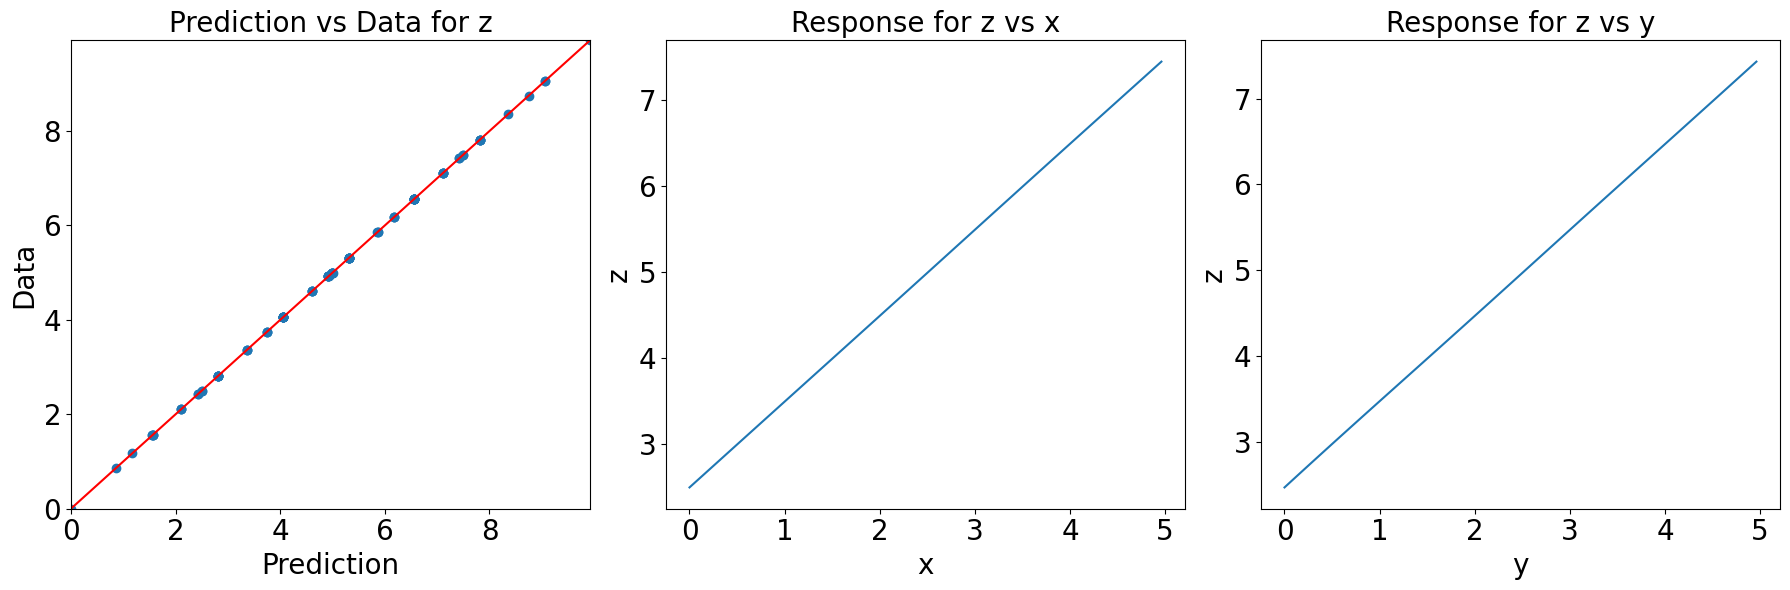

nrmse 0.00017142272922835415


In [10]:
params = RegressorPlotParameters(regressor,
                                 regressor.parameters.input_data.mean(),
                                 regressor.parameters.input_data.min(),
                                 regressor.parameters.input_data.max())

reg_plot = RegressorPlot(params)

reg_plot.plot()

print("nrmse", regressor.error_metrics()['nrmse'])

# Lets look at the changed parameters

In [11]:
after = pd.Series({'batch_size':regressor.parameters.batch_size,
                    'learning_rate_init':regressor.parameters.learning_rate_init,
                    'learning_rate_factor':regressor.parameters.learning_rate_factor,
                    'hidden_layer_sizes':regressor.parameters.hidden_layer_sizes,
                    'nrmse':regressor.error_metrics()['nrmse']})

In [12]:
pd.DataFrame({'before':before, 'after':after})

,before,after
batch_size,4,128
learning_rate_init,0.001,0.004668
learning_rate_factor,0.5,0.825653
hidden_layer_sizes,"(2,)","[128, 32, 64, 16, 128]"
nrmse,0.010063,0.000171
